In [1]:
import math
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import time

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [2]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

NUM_FEATURES = 21
NUM_CLASSES = 3

learning_rate = 0.01
epochs = 2000
beta = [0, 1e-3, 1e-6, 1e-9, 1e-12]
batch_size = 16
num_neurons = 10
seed = 10
np.random.seed(seed)

#read train data

train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
trainX, train_Y = train_input[1:, :21], train_input[1:,-1].astype(int)
#split dataset in 70:30
X_train, X_test, Ytrain, Ytest = train_test_split(trainX, train_Y, test_size=0.3, random_state=20, shuffle=True)

X_train = scale(X_train, np.min(X_train, axis=0), np.max(X_train, axis=0))
X_test = scale(X_test, np.min(X_test, axis=0), np.max(X_test, axis=0))

Y_train = np.zeros((Ytrain.shape[0], NUM_CLASSES))
Y_train[np.arange(Ytrain.shape[0]), Ytrain-1] = 1 #one hot matrix

Y_test = np.zeros((Ytest.shape[0], NUM_CLASSES))
Y_test[np.arange(Ytest.shape[0]), Ytest-1] = 1 #one hot matrix

n = X_train.shape[0]
    
# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])


In [3]:
kf = KFold(n_splits=5, random_state=20, shuffle=True)
N = len(X_train)

acc_fold = []
mean_acc_beta = []
totalmean_acc_beta = []
for b in beta:
    # Build the graph for the deep net
	
    #Build 1st layer to hidden layer
    weights_to_h = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights_to_h')
    biases_to_h  = tf.Variable(tf.zeros([num_neurons]), name='biases_to_h')
    hidden1 = tf.nn.relu(tf.matmul(x, weights_to_h) + biases_to_h)

    #Build 2nd layer to output layer (softmax layer)
    weights_to_o = tf.Variable(tf.truncated_normal([NUM_FEATURES, NUM_CLASSES], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights_to_o')
    biases_to_o  = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_to_o')
    logits  = tf.matmul(x, weights_to_o) + biases_to_o

    #L2 regularization with weight decay
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    regularization = tf.nn.l2_loss(weights_to_h) + tf.nn.l2_loss(weights_to_o)
    loss = tf.reduce_mean(cross_entropy + b*regularization)

    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    
    print("Decay Parameter: " + str(b))
    fold = 1
    acc_fold = []
    for train_index, test_index in kf.split(X_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        print("Fold number: " + str(fold))
        X_traink, X_testk = X_train[train_index], X_train[test_index]
        Y_traink, Y_testk = Y_train[train_index], Y_train[test_index]
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            train_acc = []
            test_acc = []

            for i in range(epochs):
                
                for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                    train_op.run(feed_dict={x: X_traink[start:end], y_: Y_traink[start:end]})

                train_acc.append(accuracy.eval(feed_dict={x: X_traink, y_: Y_traink}))
                test_acc.append(accuracy.eval(feed_dict={x: X_testk, y_: Y_testk}))

                if i % 100 == 0:
                    print('iter %d: Train accuracy %g'%(i, train_acc[i]))
                    print('iter %d: Test accuracy %g'%(i, test_acc[i]))
            
        #store accuracy of each fold
        acc_fold.append(test_acc)
        fold += 1

    #find mean accuracy of each batch
    mean_acc = np.mean(np.array(acc_fold), axis=0)
    mean_acc_beta.append(mean_acc)
    
    #find total mean accuracy of each batch
    totalmean_acc = np.mean(np.array(mean_acc_beta), axis=0)
    totalmean_acc_beta.append(totalmean_acc.mean())

Decay Parameter: 0
Fold number: 1
iter 0: Train accuracy 0.794118
iter 0: Test accuracy 0.785235
iter 100: Train accuracy 0.84874
iter 100: Test accuracy 0.83557
iter 200: Train accuracy 0.869748
iter 200: Test accuracy 0.869128
iter 300: Train accuracy 0.880672
iter 300: Test accuracy 0.885906
iter 400: Train accuracy 0.888235
iter 400: Test accuracy 0.895973
iter 500: Train accuracy 0.891597
iter 500: Test accuracy 0.895973
iter 600: Train accuracy 0.895798
iter 600: Test accuracy 0.892617
iter 700: Train accuracy 0.89916
iter 700: Test accuracy 0.895973
iter 800: Train accuracy 0.89916
iter 800: Test accuracy 0.892617
iter 900: Train accuracy 0.9
iter 900: Test accuracy 0.892617
iter 1000: Train accuracy 0.901681
iter 1000: Test accuracy 0.895973
iter 1100: Train accuracy 0.904202
iter 1100: Test accuracy 0.895973
iter 1200: Train accuracy 0.902521
iter 1200: Test accuracy 0.895973
iter 1300: Train accuracy 0.902521
iter 1300: Test accuracy 0.892617
iter 1400: Train accuracy 0.90168

Fold number: 2
iter 0: Train accuracy 0.781513
iter 0: Test accuracy 0.83557
iter 100: Train accuracy 0.847899
iter 100: Test accuracy 0.869128
iter 200: Train accuracy 0.87563
iter 200: Test accuracy 0.875839
iter 300: Train accuracy 0.879832
iter 300: Test accuracy 0.88255
iter 400: Train accuracy 0.882353
iter 400: Test accuracy 0.885906
iter 500: Train accuracy 0.885714
iter 500: Test accuracy 0.889262
iter 600: Train accuracy 0.889916
iter 600: Test accuracy 0.889262
iter 700: Train accuracy 0.889916
iter 700: Test accuracy 0.892617
iter 800: Train accuracy 0.892437
iter 800: Test accuracy 0.892617
iter 900: Train accuracy 0.893277
iter 900: Test accuracy 0.895973
iter 1000: Train accuracy 0.893277
iter 1000: Test accuracy 0.895973
iter 1100: Train accuracy 0.892437
iter 1100: Test accuracy 0.899329
iter 1200: Train accuracy 0.893277
iter 1200: Test accuracy 0.899329
iter 1300: Train accuracy 0.894118
iter 1300: Test accuracy 0.899329
iter 1400: Train accuracy 0.894118
iter 1400: 

Fold number: 3
iter 0: Train accuracy 0.795798
iter 0: Test accuracy 0.798658
iter 100: Train accuracy 0.846218
iter 100: Test accuracy 0.872483
iter 200: Train accuracy 0.87395
iter 200: Test accuracy 0.892617
iter 300: Train accuracy 0.883193
iter 300: Test accuracy 0.889262
iter 400: Train accuracy 0.887395
iter 400: Test accuracy 0.899329
iter 500: Train accuracy 0.889076
iter 500: Test accuracy 0.895973
iter 600: Train accuracy 0.891597
iter 600: Test accuracy 0.899329
iter 700: Train accuracy 0.892437
iter 700: Test accuracy 0.902685
iter 800: Train accuracy 0.894118
iter 800: Test accuracy 0.90604
iter 900: Train accuracy 0.894118
iter 900: Test accuracy 0.902685
iter 1000: Train accuracy 0.895798
iter 1000: Test accuracy 0.902685
iter 1100: Train accuracy 0.896639
iter 1100: Test accuracy 0.899329
iter 1200: Train accuracy 0.89916
iter 1200: Test accuracy 0.902685
iter 1300: Train accuracy 0.89916
iter 1300: Test accuracy 0.902685
iter 1400: Train accuracy 0.89916
iter 1400: Te

Fold number: 4
iter 0: Train accuracy 0.79429
iter 0: Test accuracy 0.784512
iter 100: Train accuracy 0.853065
iter 100: Test accuracy 0.83165
iter 200: Train accuracy 0.876574
iter 200: Test accuracy 0.858586
iter 300: Train accuracy 0.887489
iter 300: Test accuracy 0.86532
iter 400: Train accuracy 0.894207
iter 400: Test accuracy 0.868687
iter 500: Train accuracy 0.900924
iter 500: Test accuracy 0.868687
iter 600: Train accuracy 0.898405
iter 600: Test accuracy 0.872054
iter 700: Train accuracy 0.900084
iter 700: Test accuracy 0.872054
iter 800: Train accuracy 0.900084
iter 800: Test accuracy 0.872054
iter 900: Train accuracy 0.901763
iter 900: Test accuracy 0.872054
iter 1000: Train accuracy 0.901763
iter 1000: Test accuracy 0.872054
iter 1100: Train accuracy 0.903443
iter 1100: Test accuracy 0.872054
iter 1200: Train accuracy 0.904282
iter 1200: Test accuracy 0.875421
iter 1300: Train accuracy 0.903443
iter 1300: Test accuracy 0.875421
iter 1400: Train accuracy 0.902603
iter 1400: 

Fold number: 5
iter 0: Train accuracy 0.800168
iter 0: Test accuracy 0.760943
iter 100: Train accuracy 0.847187
iter 100: Test accuracy 0.811448
iter 200: Train accuracy 0.875735
iter 200: Test accuracy 0.858586
iter 300: Train accuracy 0.890008
iter 300: Test accuracy 0.872054
iter 400: Train accuracy 0.895046
iter 400: Test accuracy 0.878788
iter 500: Train accuracy 0.894207
iter 500: Test accuracy 0.878788
iter 600: Train accuracy 0.895886
iter 600: Test accuracy 0.878788
iter 700: Train accuracy 0.896725
iter 700: Test accuracy 0.882155
iter 800: Train accuracy 0.896725
iter 800: Test accuracy 0.882155
iter 900: Train accuracy 0.899244
iter 900: Test accuracy 0.882155
iter 1000: Train accuracy 0.900924
iter 1000: Test accuracy 0.882155
iter 1100: Train accuracy 0.900924
iter 1100: Test accuracy 0.888889
iter 1200: Train accuracy 0.900924
iter 1200: Test accuracy 0.888889
iter 1300: Train accuracy 0.900084
iter 1300: Test accuracy 0.888889
iter 1400: Train accuracy 0.901763
iter 140

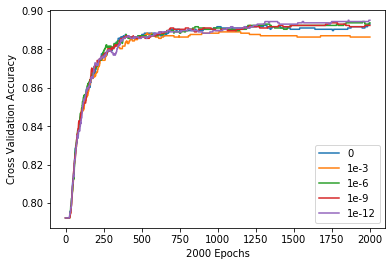

In [4]:
# 2a) plot CV accuracy against number of epochs for different batch size           
plt.figure(1)
plt.plot(range(epochs), mean_acc_beta[0], label = "0")
plt.plot(range(epochs), mean_acc_beta[1], label = "1e-3")
plt.plot(range(epochs), mean_acc_beta[2], label = "1e-6")
plt.plot(range(epochs), mean_acc_beta[3], label = "1e-9")
plt.plot(range(epochs), mean_acc_beta[4], label = "1e-12")
plt.xlabel(str(epochs) + ' Epochs')
plt.ylabel('Cross Validation Accuracy')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Accuracy vs. Decay Parameter')

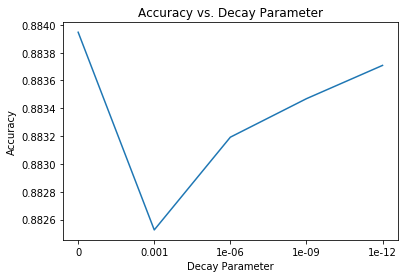

In [5]:
# plot mean CV accuracy against no. of neurons
plt.figure(2)
plt.plot(range(len(beta)), totalmean_acc_beta)
plt.xticks(range(len(beta)), beta)
plt.xlabel('Decay Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Decay Parameter')

Fold number: 1
iter 0: Train accuracy 0.794118
iter 0: Test accuracy 0.785235
iter 100: Train accuracy 0.85126
iter 100: Test accuracy 0.832215
iter 200: Train accuracy 0.872269
iter 200: Test accuracy 0.865772
iter 300: Train accuracy 0.880672
iter 300: Test accuracy 0.892617
iter 400: Train accuracy 0.889076
iter 400: Test accuracy 0.895973
iter 500: Train accuracy 0.890756
iter 500: Test accuracy 0.895973
iter 600: Train accuracy 0.896639
iter 600: Test accuracy 0.895973
iter 700: Train accuracy 0.897479
iter 700: Test accuracy 0.892617
iter 800: Train accuracy 0.897479
iter 800: Test accuracy 0.892617
iter 900: Train accuracy 0.89916
iter 900: Test accuracy 0.892617
iter 1000: Train accuracy 0.90084
iter 1000: Test accuracy 0.895973
iter 1100: Train accuracy 0.903361
iter 1100: Test accuracy 0.895973
iter 1200: Train accuracy 0.903361
iter 1200: Test accuracy 0.895973
iter 1300: Train accuracy 0.903361
iter 1300: Test accuracy 0.889262
iter 1400: Train accuracy 0.904202
iter 1400: 

Text(0.5, 1.0, 'Training Accuracy vs. No. Of Epochs')

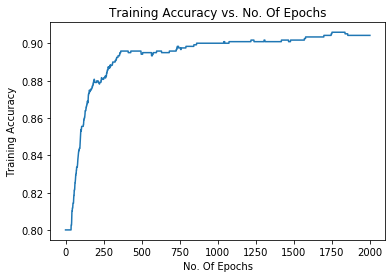

In [6]:
# Build the graph for the deep net
#optimum decay parameter = 0
	
#Build 1st layer to hidden layer
weights_to_h = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights_to_h')
biases_to_h  = tf.Variable(tf.zeros([num_neurons]), name='biases_to_h')
hidden1 = tf.nn.relu(tf.matmul(x, weights_to_h) + biases_to_h)

#Build 2nd layer to output layer (softmax layer)
weights_to_o = tf.Variable(tf.truncated_normal([NUM_FEATURES, NUM_CLASSES], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights_to_o')
biases_to_o  = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_to_o')
logits  = tf.matmul(x, weights_to_o) + biases_to_o

#L2 regularization with weight decay
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
regularization = tf.nn.l2_loss(weights_to_h) + tf.nn.l2_loss(weights_to_o)
loss = tf.reduce_mean(cross_entropy + 0*regularization)

# Create the gradient descent optimizer with the given learning rate.
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

fold = 1
acc_fold = []
for train_index, test_index in kf.split(X_train):
    print("Fold number: " + str(fold))
    X_traink, X_testk = X_train[train_index], X_train[test_index]
    Y_traink, Y_testk = Y_train[train_index], Y_train[test_index]

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_acc = []
        test_acc = []

        for i in range(epochs):
                
            for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                train_op.run(feed_dict={x: X_traink[start:end], y_: Y_traink[start:end]})

            train_acc.append(accuracy.eval(feed_dict={x: X_traink, y_: Y_traink}))
            test_acc.append(accuracy.eval(feed_dict={x: X_testk, y_: Y_testk}))

            if i % 100 == 0:
                print('iter %d: Train accuracy %g'%(i, train_acc[i]))
                print('iter %d: Test accuracy %g'%(i, test_acc[i]))
            

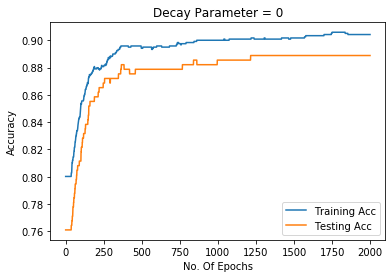

In [10]:
# plot training and testing accuracy against no. of epochs
plt.figure(2)
plt.plot(range(epochs), train_acc, label = "Training Acc")
plt.plot(range(epochs), test_acc, label = "Testing Acc")
plt.xlabel('No. Of Epochs')
plt.ylabel('Accuracy')
plt.title('Decay Parameter = 0')
plt.legend()